# Backdoor Unlearning

## Outline

1. Experimental setup (generating configs)
2. Clean model training
3. Poisoned model training
4. First-order unlearning
5. Second-order unlearning
6. Visualizing results


## Experimental Setup

- All configurations to test are defined in the `[train|poison|unlearn].json` files (see below).
- If parameters are passed as list, all their combinations are tested in a grid-search manner.
- Only a single combination is provided for this demo. The original combinations are in `Applications/Poisoning/configs`
- The function generates directories and configuration files for each combination. They are later used by an evaluation script to run the experiment. This allows for parallelization and distributed execution.

In [2]:
import sys
sys.path.append('../')


In [3]:
# only if you are using CUDA devices
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [4]:
from conf import BASE_DIR
from Applications.Poisoning.gen_configs import main as gen_configs

model_folder = BASE_DIR/'models'/'poisoning'
train_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'train.json'
poison_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'poison.json'
unlearn_conf = BASE_DIR/'Applications'/'Poisoning'/'configs'/'demo'/'unlearn.json'

gen_configs(model_folder, train_conf, poison_conf, unlearn_conf)

In [5]:
from Applications.Poisoning.poison.poison_models import train_poisoned
from Applications.Poisoning.configs.demo.config import Config

poisoned_folder = model_folder/'budget-10000'/'seed-42'
clean_folder = model_folder/'clean'
first_unlearn_folder = model_folder/'budget-10000'/'seed-42'/'first-order'
second_unlearn_folder = model_folder/'budget-10000'/'seed-42'/'second-order'


poison_kwargs = Config.from_json(poisoned_folder/'poison_config.json')
train_kwargs = Config.from_json(poisoned_folder/'train_config.json')


2024-07-08 20:52:29.007092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-12.2/lib64
2024-07-08 20:52:29.007150: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Clean Model Training

- Train a clean model for reference.

## Train Poisoned Model

- Select one of the generated configurations and train a poisoned model.
- The poisoning uses an `injector` object which can be persisted for reproducibility. It will inject the backdoors/label noise into the same samples according to a seed. In our experiments, we worked with label noise poisoning.

In [6]:
from Applications.Poisoning.poison.poison_models import train_poisoned
from Applications.Poisoning.configs.demo.config import Config

poisoned_folder = model_folder/'budget-10000'/'seed-42'
clean_folder = model_folder/'clean'
first_unlearn_folder = model_folder/'budget-10000'/'seed-42'/'first-order'
second_unlearn_folder = model_folder/'budget-10000'/'seed-42'/'second-order'


poison_kwargs = Config.from_json(poisoned_folder/'poison_config.json')
train_kwargs = Config.from_json(poisoned_folder/'train_config.json')



In [7]:
poisoned_weights = poisoned_folder/'best_model.hdf5'       # model that has been trained on poisoned data
fo_repaired_weights = poisoned_folder/'fo_repaired.hdf5'   # model weights after unlearning (first-order)
so_repaired_weights = poisoned_folder/'so_repaired.hdf5'   # model weights after unlearning (second-order)
injector_path = poisoned_folder/'injector.pkl'             # cached injector for reproducibility
clean_results = model_folder/'clean'/'train_results.json'  # path to reference results on clean dataset


## Unlearning

- Perform the first-order and second-order unlearning. The unlearning is wrapped in a function that
    - loads the clean data, saves the original labels
    - injects the poison (label noise)
    - creates difference set Z using `injector.injected_idx`
    - main unlearning happens in `Applications.Poisoning.unlearn.common.py:unlearn_update` and the thereby called `iter_approx_retraining` method
- The variable naming follows the following ideas:
    - `z_x`, `z_y`: features (x) and labels (y) in set `Z`
    - `z_x_delta`, `z_y_delta`: changed features and labels (`z_x == z_x_delta` here and `z_y_delta` contains the original (fixed) labels)
- A word about why iterative:
    - The approximate retraining is configured to unlearn the desired changes in one step.
    - To avoid putting a lot of redundant erroneous samples in the changing set `Z`, the iterative version
        - takes a sub-sample (`prio_idx`) of `hvp_batch_size` in the delta set `Z`
        - makes one unlearning step
        - recalculates the delta set and focuses only on remaining errors
    - The idea here is that similar to learning, it is better to work iteratively in batches since the approximation quality of the inverse hessian matrix decreases with the number of samples included (and the step size)

In [8]:
from Applications.Poisoning.unlearn.first_order import run_experiment as fo_experiment
from Applications.Poisoning.unlearn.second_order import run_experiment as so_experiment

fo_unlearn_kwargs = Config.from_json(poisoned_folder/'first-order'/'unlearn_config.json')
so_unlearn_kwargs = Config.from_json(poisoned_folder/'second-order'/'unlearn_config.json')


In [9]:
from Applications.Poisoning.train import main as train
from Applications.Poisoning.evaluate import evaluate

# train one clean and one poisoned model
# datasets = ['Cifar10', 'Cifar100', 'SVHN', 'FashionMnist']
datasets = ['Cifar100', 'SVHN', 'Cifar10']
modelnames = ['VGG16']
# modelnames = ['VGG16', 'RESNET50']

****************************************
* Training VGG16 on Cifar100 started. *
****************************************
Result will be saved to: /home/ameck.dosseh/conite/MachineUnlearningUpdate/models/poisoning/clean/Cifar100_VGG16_train_results.json


2024-07-03 14:49:30.733270: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/team1337/.local/easybuild_new/software/OpenMPI/4.0.5-GCC-10.2.0/lib:/home/team1337/.local/easybuild_new/software/PMIx/3.1.5-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libfabric/1.11.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/UCX/1.9.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libevent/2.1.12-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/hwloc/2.2.0-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libpciaccess/0.16-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/libxml2/2.9.10-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/XZ/5.2.5-GCCcore-10.2.0/lib:/home/team1337/.local/easybuild_new/software/numactl/2.0.13-GCCcore-

Loading weights from None
Saving results to: /home/ameck.dosseh/conite/MachineUnlearningUpdate/models/poisoning/clean/Cifar100_VGG16_train_results.json
Results saved to: /home/ameck.dosseh/conite/MachineUnlearningUpdate/models/poisoning/clean/Cifar100_VGG16_train_results.json
****************************************
* Training VGG16 on Cifar100 done. *
****************************************
Loading weights from None
Model weights loaded successfully from /home/ameck.dosseh/conite/MachineUnlearningUpdate/models/poisoning/clean/Cifar100_VGG16_best_model.hdf5.
Accuracy Cifar100 model: 0.6148
****************************************
* Training RESNET50 on Cifar100 started. *
****************************************
Result will be saved to: /home/ameck.dosseh/conite/MachineUnlearningUpdate/models/poisoning/clean/Cifar100_RESNET50_train_results.json
Loading weights from None
Saving results to: /home/ameck.dosseh/conite/MachineUnlearningUpdate/models/poisoning/clean/Cifar100_RESNET50_train_

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

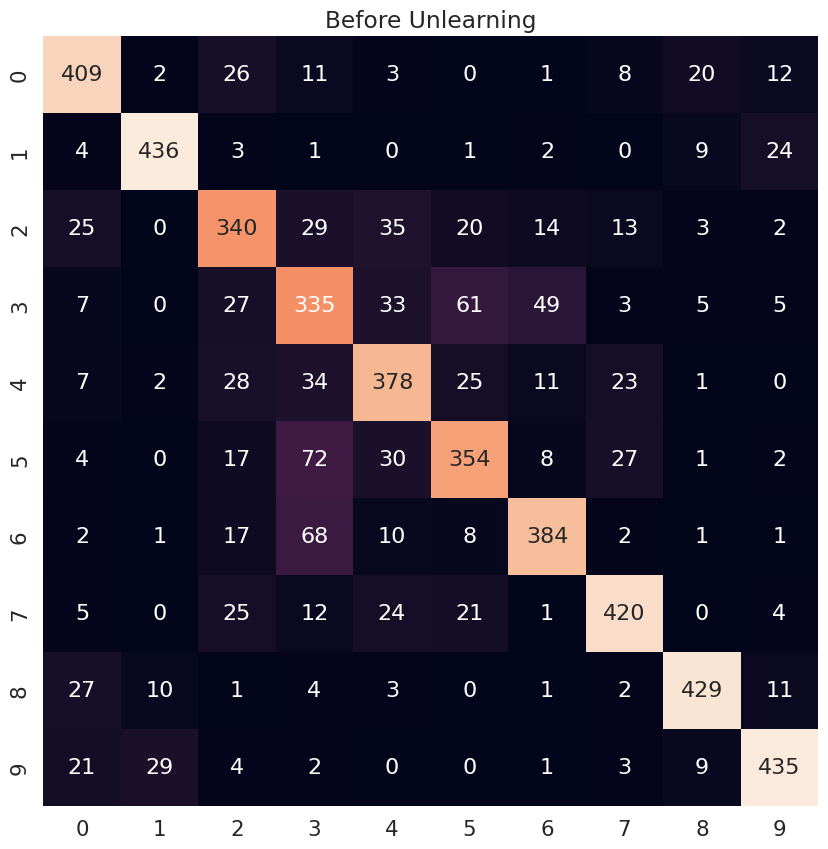

In [9]:
import json
import os

results = {
    'clean': {},
    'poisoned': {},
    'first_order_unlearning': {},
    'second_order_unlearning': {}
}

for dataset in datasets:
    results['clean'][dataset] = {}
    results['poisoned'][dataset] = {}
    results['first_order_unlearning'][dataset] = {}
    results['second_order_unlearning'][dataset] = {}
    
    # print('#' * 60)
    # print(f" TRAINING ")
    # print('#' * 60)
    # print('\n\n')
    # for modelname in modelnames:
    #     print('*' * 60)
    #     print(f"* Training {modelname} on {dataset} started. *")
    #     print('*' * 60)
    #     train(model_folder=model_folder/'clean', dataset=dataset, modelname=modelname)
    #     print('*' * 60)
    #     print(f"* Training {modelname} on {dataset} done. *")
    #     print('*' * 60)
    #     clean_accuracy = evaluate(model_folder=model_folder/'clean', dataset=dataset, modelname=modelname, type='best')
    #     results['clean'][dataset][modelname] = clean_accuracy

    # print('#' * 60)
    # print(f" POISONING ")
    # print('#' * 60)
    # print('\n\n')
    # for modelname in modelnames:
    #     print('*' * 60)
    #     print(f"* Poisoning {modelname} on {dataset} started. *")
    #     print('*' * 60)
    #     train_poisoned(model_folder=poisoned_folder, poison_kwargs=poison_kwargs, train_kwargs=train_kwargs, dataset=dataset, modelname=modelname)
    #     print('*' * 60)
    #     print(f"* Poisoning {modelname} on {dataset} done. *")
    #     print('*' * 60)
    #     poisoned_accuracy = evaluate(model_folder=poisoned_folder, dataset=dataset, modelname=modelname, type='poisoned')
    #     results['poisoned'][dataset][modelname] = poisoned_accuracy

    # unlearn the poisoned model
    print('#' * 60)
    print(f" UNLEARNING ")
    print('#' * 60)
    print('\n\n')

    for modelname in modelnames:
        print(f"* Evaluating {modelname} on {dataset} poisoned model *")
        poisoned_accuracy = evaluate(model_folder=poisoned_folder, dataset=dataset, modelname=modelname, type='poisoned')
        results['poisoned'][dataset][modelname] = poisoned_accuracy
        
        print(f"* First-order unlearning {modelname} on {dataset} poisoned model *")
        try:
            fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs, dataset=dataset, modelname=modelname, update_target='feature_extractor')
        
            print(f"* Evaluating {modelname} on {dataset} after first-order unlearning *")
            fo_repaired_accuracy = evaluate(model_folder=first_unlearn_folder, dataset=dataset, modelname=modelname, type='repaired')
            results['first_order_unlearning'][dataset][modelname] = fo_repaired_accuracy
        except Exception as e:
            print(f"Error during first-order unlearning for {modelname} on {dataset}: {e}")
            continue


        print(f"* Second-order unlearning {modelname} on {dataset} poisoned model *")
        try:
            so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs, dataset=dataset, modelname=modelname, update_target='classifier')

            print(f"* Evaluating {modelname} on {dataset} after second-order unlearning *")
            so_repaired_accuracy = evaluate(model_folder=second_unlearn_folder, dataset=dataset, modelname=modelname, type='repaired')
            results['second_order_unlearning'][dataset][modelname] = so_repaired_accuracy
        except Exception as e:
            print(f"Error during second-order unlearning for {modelname} on {dataset}: {e}")
            continue


In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import DataLoader
import tensorflow as tf
from tensorflow.keras.models import load_model

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def calculate_confidence(model, x_data):
    y_pred = model.predict(x_data)
    probs = tf.nn.softmax(y_pred, axis=1).numpy()
    max_probs = np.max(probs, axis=1)
    return max_probs


def calculate_confusion_matrix(model, x_data, y_true):
    y_pred = model.predict(x_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else y_true
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    accuracy = np.trace(cm) / np.sum(cm)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn, fp, fn, tp = 0, 0, 0, 0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                if i == j:
                    if i == 1:
                        tp = cm[i, j]
                    else:
                        tn += cm[i, j]
                else:
                    if i == 1:
                        fn += cm[i, j]
                    else:
                        fp += cm[i, j]
    return tn, fp, fn, tp

def calculate_forget_score(tn_before, fp_before, fn_before, tp_before, tn_after, fp_after, fn_after, tp_after):
    delta = 0.01
    tpr_before = tp_before / (tp_before + fn_before + delta)
    fpr_before = fp_before / (fp_before + tn_before + delta)
    tpr_after = tp_after / (tp_after + fn_after + delta)
    fpr_after = fp_after / (fp_after + tn_after + delta)

    epsilon = np.nanmax([
        np.log(1 - delta - fpr_after) - np.log(tpr_after),
        np.log(1 - delta - fn_after) - np.log(tpr_after),
        np.log(1 - delta - fpr_before) - np.log(tpr_before),
        np.log(1 - delta - fn_before) - np.log(tpr_before)
    ])

    return epsilon


def plot_confusion_matrix(y_true, y_pred, title):
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def evaluate_model_accuracy(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    return accuracy

def load_and_evaluate_models(datasets, models, clean_folder, unlearn_folder):
    results = {}
    
    for dataset_name, dataset in datasets.items():
        results[dataset_name] = {}
        
        # Load the dataset
        (x_train, y_train), (x_test, y_test), (x_valid, y_valid) = dataset.load()
        
        for model_name in models[dataset_name]:
            model_fn = models[dataset_name][model_name]
            results[dataset_name][model_name] = {}
            print(f"Evaluating {model_name} on {dataset_name}")
            
            try:
                # Load the clean model
                model_clean = model_fn()
                model_clean.load_weights(clean_folder / f'{model_name}_best_model.hdf5')

                # Load the unlearned model
                model_unlearned = model_fn()
                model_unlearned.load_weights(unlearn_folder / f'{model_name}_repaired_model.hdf5')
            except:
                print(f"Error loading models for {model_name} on {dataset_name}")
                continue
            # Evaluate the accuracy of the models
            accuracy_clean = evaluate_model_accuracy(model_clean, x_test, y_test)
            accuracy_unlearned = evaluate_model_accuracy(model_unlearned, x_test, y_test)
            print(f"Accuracy of the clean model: {accuracy_clean:.4f}")
            print(f"Accuracy of the unlearned model: {accuracy_unlearned:.4f}")

            # Compute confusion matrix for clean model
            y_pred_clean = model_clean.predict(x_test).argmax(axis=1)
            #plot_confusion_matrix(y_test, y_pred_clean, f'{model_name} Clean Model Confusion Matrix')

            # Compute confusion matrix for unlearned model
            y_pred_unlearned = model_unlearned.predict(x_test).argmax(axis=1)
            #plot_confusion_matrix(y_test, y_pred_unlearned, f'{model_name} Unlearned Model Confusion Matrix')


            # Compute confidence and confusion matrix for clean model
            clean_confidences = calculate_confidence(model_clean, x_test)
            tn_clean, fp_clean, fn_clean, tp_clean = calculate_confusion_matrix(model_clean, x_test, y_test)

            # Compute confidence and confusion matrix for unlearned model
            unlearning_confidences = calculate_confidence(model_unlearned, x_test)
            tn_unlearned, fp_unlearned, fn_unlearned, tp_unlearned = calculate_confusion_matrix(model_unlearned, x_test, y_test)

            # Calculate forget score
            forget_score = calculate_forget_score(tn_clean, fp_clean, fn_clean, tp_clean, tn_unlearned, fp_unlearned, fn_unlearned, tp_unlearned)
            print(f"Forget Score for {model_name} on {dataset_name}: {forget_score:.4f}")

            results[dataset_name][model_name] = {
                'clean_accuracy': accuracy_clean,
                'unlearned_accuracy': accuracy_unlearned,
                'forget_score': forget_score
            }

    return results




/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Evaluating Cifar10_VGG16 on Cifar10
Loading weights from None
Loading weights from None
Accuracy of the clean model: 0.8840
Accuracy of the unlearned model: 0.8448


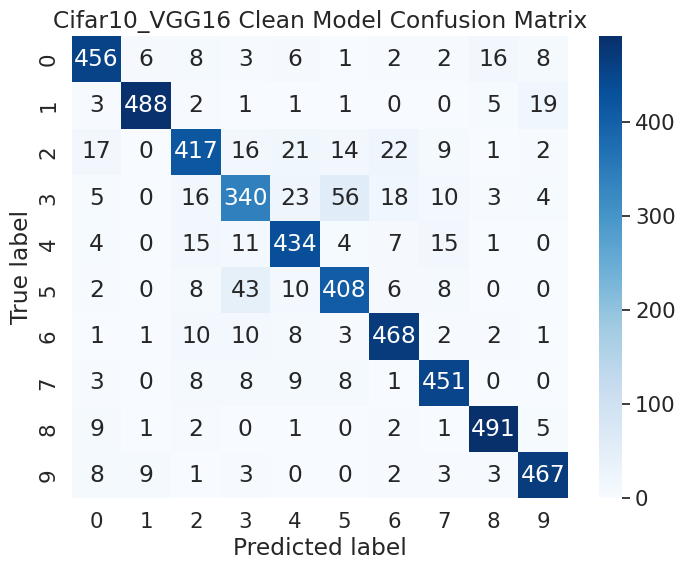

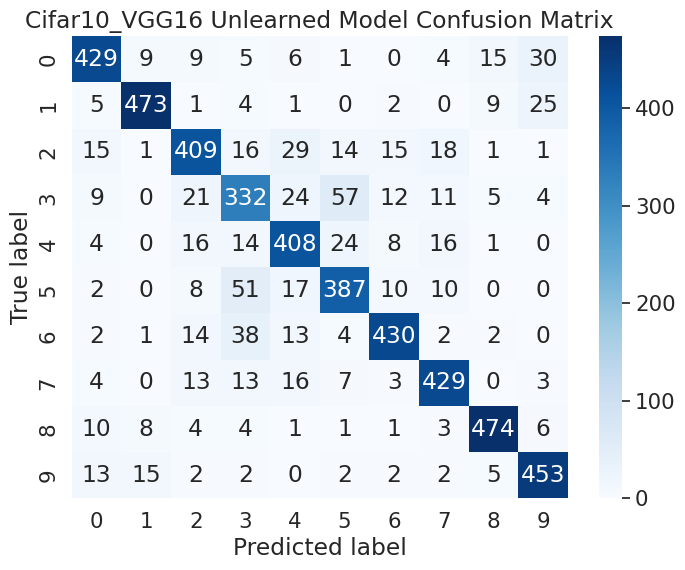

/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log
/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


Forget Score for Cifar10_VGG16 on Cifar10: -0.0784
Evaluating Cifar10_RESNET50 on Cifar10
Loading weights from None
Loading weights from None
Accuracy of the clean model: 0.7788
Accuracy of the unlearned model: 0.7384


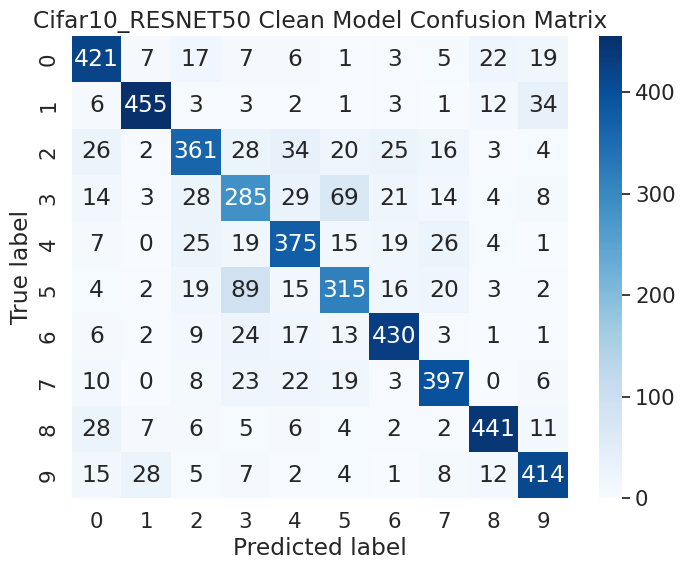

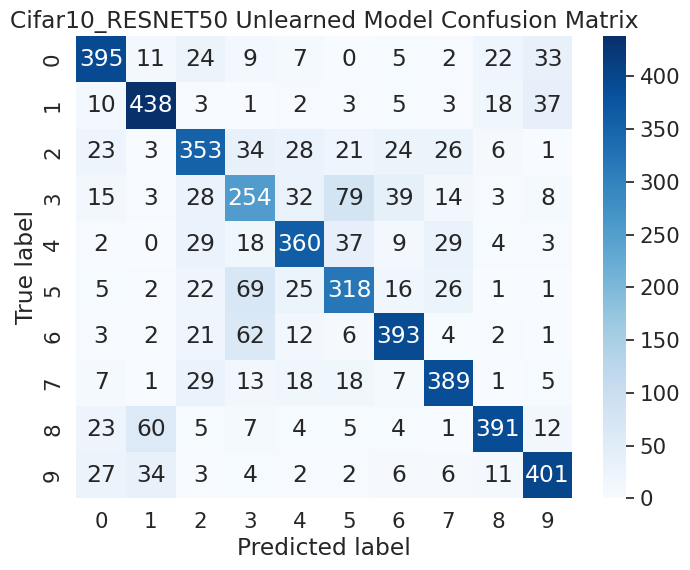

/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log
/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


Forget Score for Cifar10_RESNET50 on Cifar10: -0.1440
Evaluating Cifar10_extractfeatures_VGG16 on Cifar10
Error loading models for Cifar10_extractfeatures_VGG16 on Cifar10
Evaluating Cifar10_extractfeatures_RESNET50 on Cifar10
Error loading models for Cifar10_extractfeatures_RESNET50 on Cifar10
Evaluating Cifar10_classifier_VGG16 on Cifar10
Accuracy of the clean model: 0.6168
Accuracy of the unlearned model: 0.3588


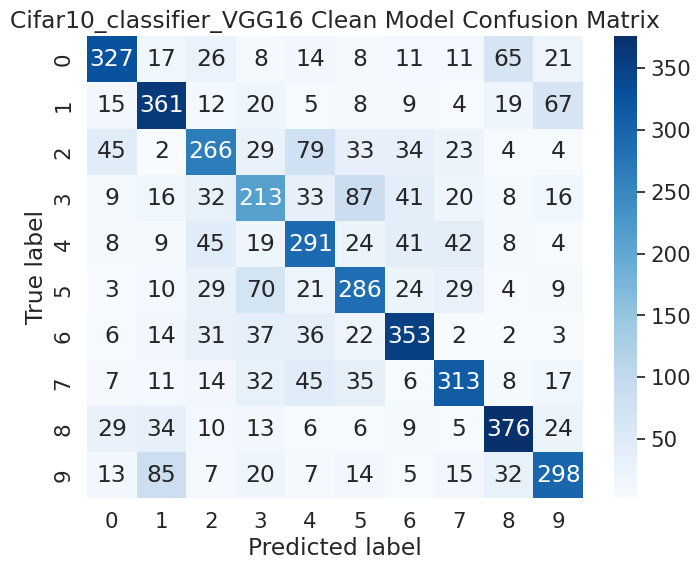

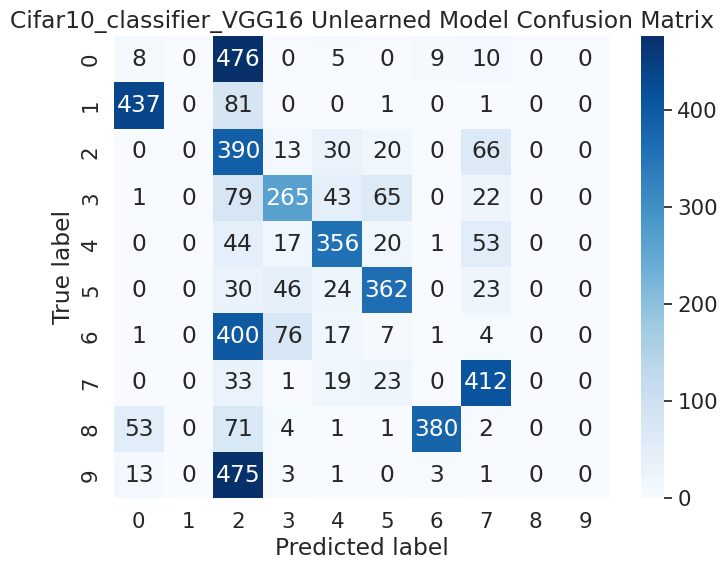

/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log
/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


Forget Score for Cifar10_classifier_VGG16 on Cifar10: inf
Evaluating Cifar10_classifier_RESNET50 on Cifar10
Accuracy of the clean model: 0.8268
Accuracy of the unlearned model: 0.7720


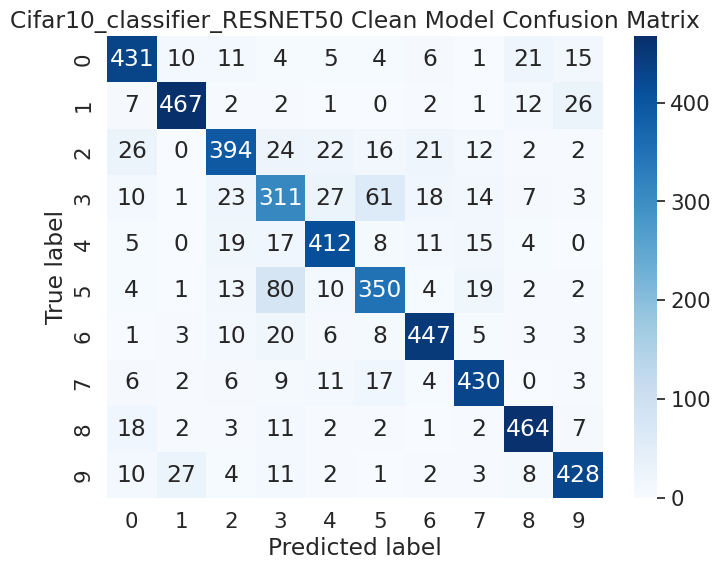

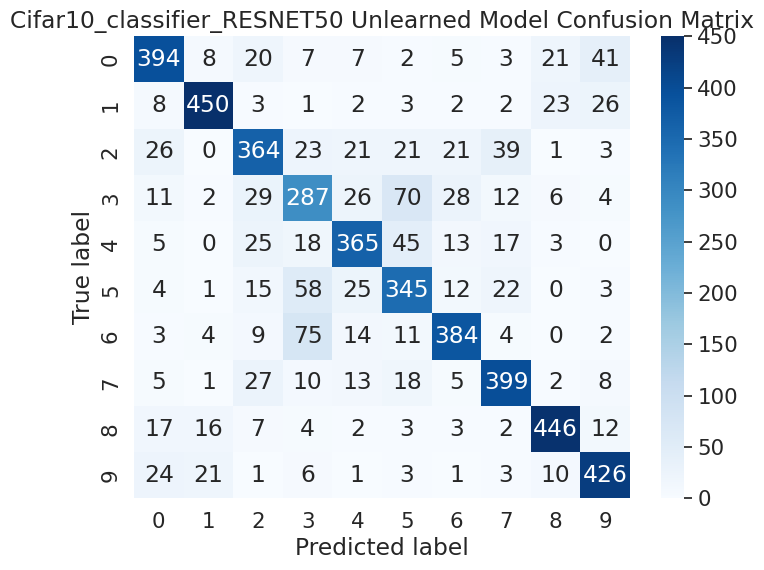

/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log
/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


Forget Score for Cifar10_classifier_RESNET50 on Cifar10: -0.1050
Evaluating SVHN_VGG16 on SVHN
Loading weights from None
Loading weights from None
Accuracy of the clean model: 0.9594
Accuracy of the unlearned model: 0.9558


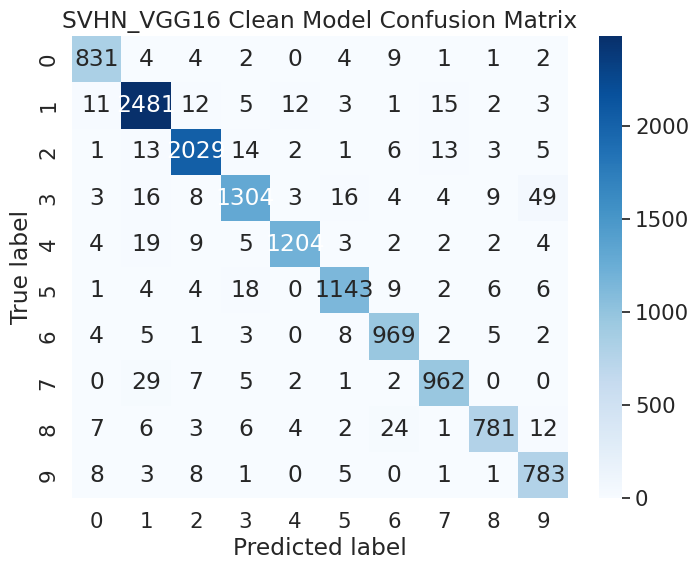

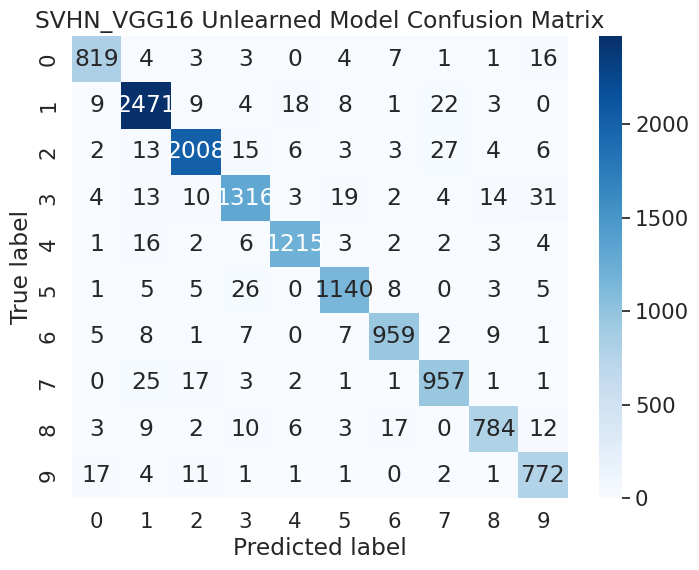

/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log
/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


Forget Score for SVHN_VGG16 on SVHN: -0.0301
Evaluating SVHN_RESNET50 on SVHN
Loading weights from None
Loading weights from None
Accuracy of the clean model: 0.9207
Accuracy of the unlearned model: 0.9348


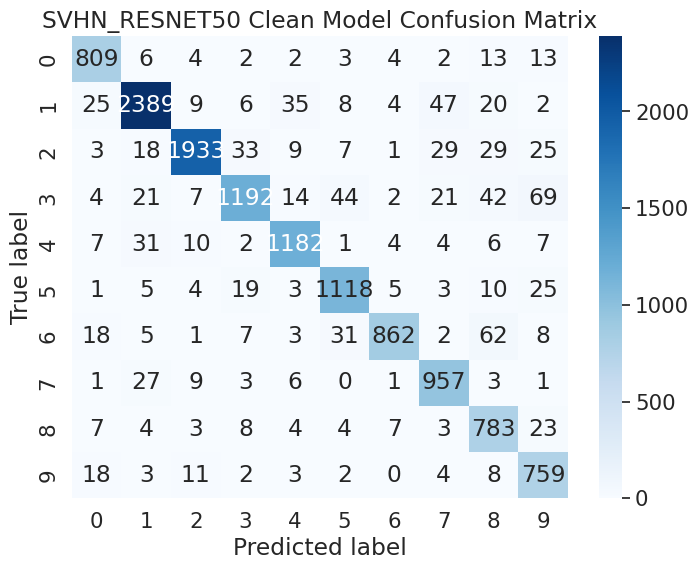

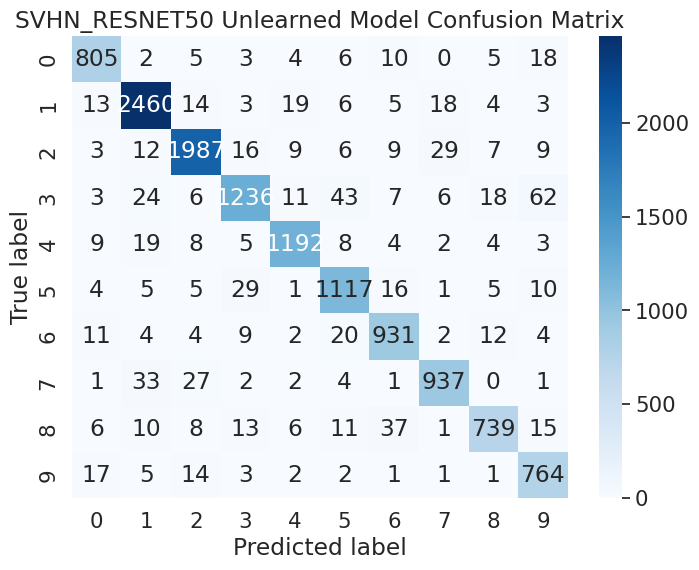

/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log
/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


Forget Score for SVHN_RESNET50 on SVHN: -0.0351
Evaluating SVHN_extractfeatures_VGG16 on SVHN
Error loading models for SVHN_extractfeatures_VGG16 on SVHN
Evaluating SVHN_extractfeatures_RESNET50 on SVHN
Error loading models for SVHN_extractfeatures_RESNET50 on SVHN
Evaluating SVHN_classifier_VGG16 on SVHN
Error loading models for SVHN_classifier_VGG16 on SVHN
Evaluating SVHN_classifier_RESNET50 on SVHN
Accuracy of the clean model: 0.8324
Accuracy of the unlearned model: 0.9312


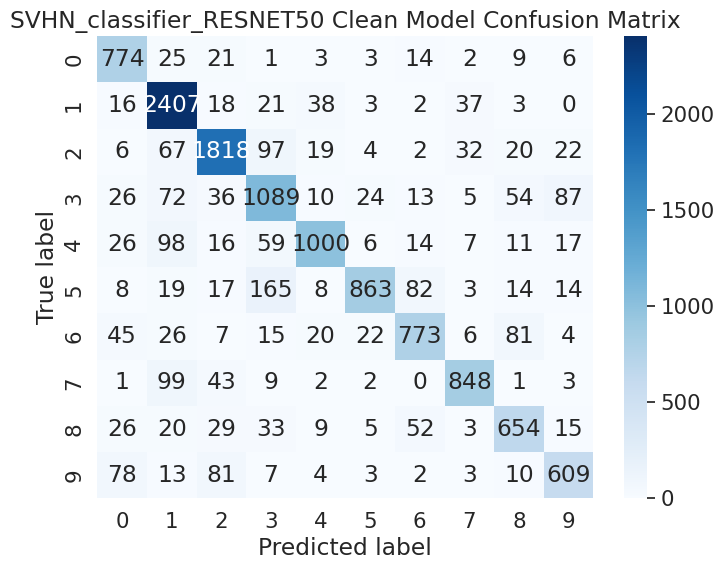

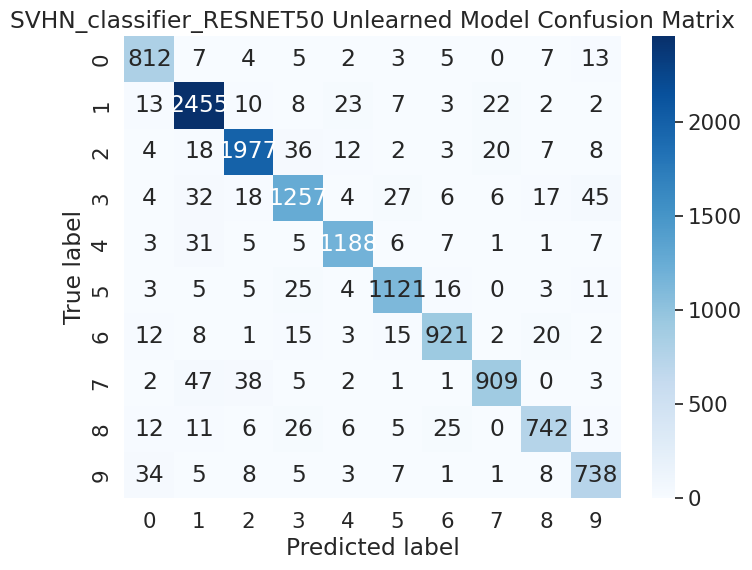

/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log
/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


Forget Score for SVHN_classifier_RESNET50 on SVHN: -0.0550
Evaluating Cifar100_VGG16 on Cifar100
Loading weights from None
Loading weights from None
Accuracy of the clean model: 0.6148
Accuracy of the unlearned model: 0.6100


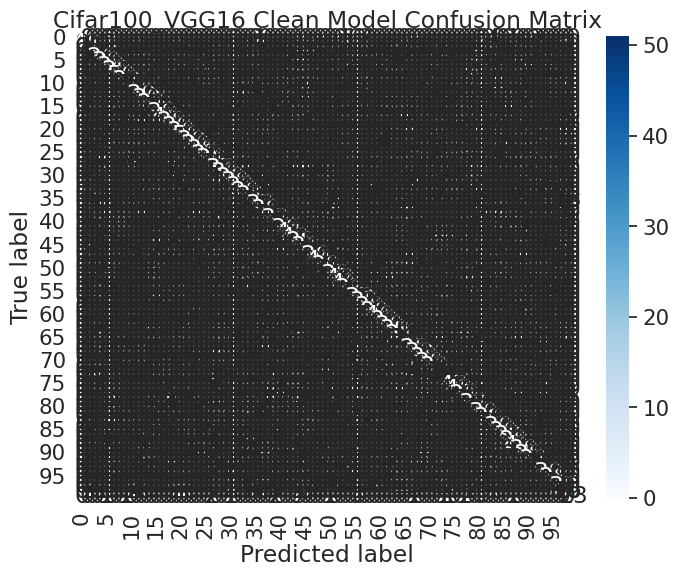

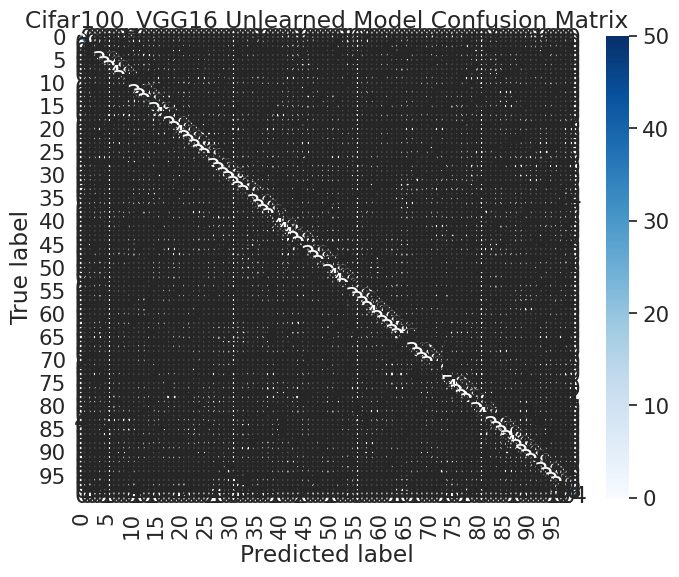

/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log
/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


Forget Score for Cifar100_VGG16 on Cifar100: -0.1443
Evaluating Cifar100_RESNET50 on Cifar100
Loading weights from None
Loading weights from None
Accuracy of the clean model: 0.4564
Accuracy of the unlearned model: 0.4370


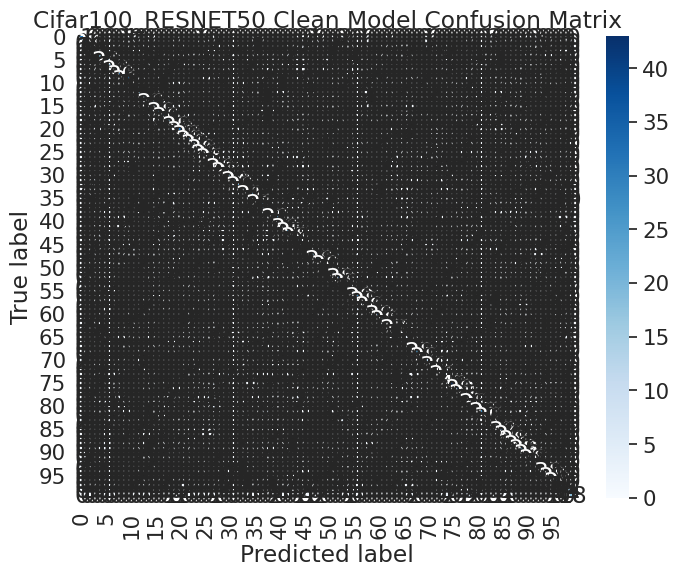

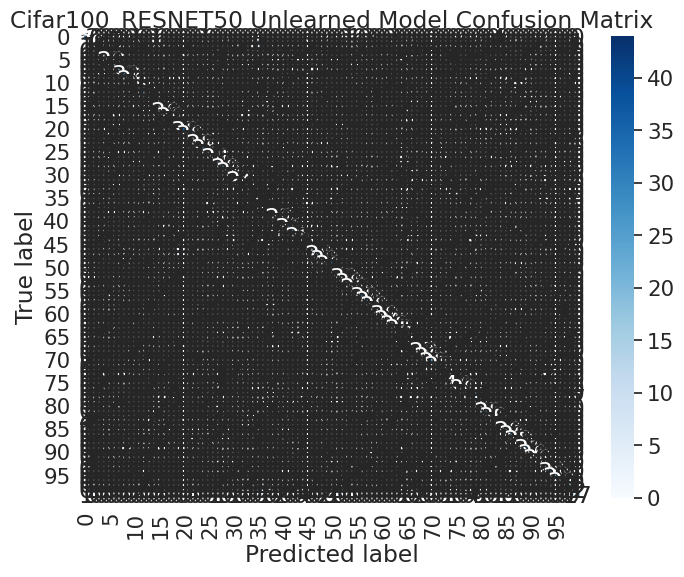

/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in log
/home/ameck.dosseh/conite/MU_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


Forget Score for Cifar100_RESNET50 on Cifar100: -0.3042
Evaluating Cifar100_extractfeatures_VGG16_CIFAR100 on Cifar100
Error loading models for Cifar100_extractfeatures_VGG16_CIFAR100 on Cifar100
Evaluating Cifar100_extractfeatures_RESNET50_CIFAR100 on Cifar100
Error loading models for Cifar100_extractfeatures_RESNET50_CIFAR100 on Cifar100
Evaluating Cifar100_classifier_VGG16_CIFAR100 on Cifar100
Error loading models for Cifar100_classifier_VGG16_CIFAR100 on Cifar100
Evaluating Cifar100_classifier_RESNET50_CIFAR100 on Cifar100
Error loading models for Cifar100_classifier_RESNET50_CIFAR100 on Cifar100
Cifar10 - Cifar10_VGG16:
  Clean Accuracy: 0.8840
  Unlearned Accuracy: 0.8448
  Forget Score: -0.0784
Cifar10 - Cifar10_RESNET50:
  Clean Accuracy: 0.7788
  Unlearned Accuracy: 0.7384
  Forget Score: -0.1440
Cifar10 - Cifar10_extractfeatures_VGG16:


KeyError: 'clean_accuracy'

In [11]:
import sys
sys.path.append('../')
# import TensorDataset
from torch.utils.data import DataLoader, TensorDataset
import os
from conf import BASE_DIR
from Applications.Poisoning.gen_configs import main as gen_configs
from Applications.Poisoning.model import extractfeatures_VGG16, classifier_VGG16, extractfeatures_RESNET50, classifier_RESNET50, get_VGG16_CIFAR100, get_VGG16_CIFAR10, get_VGG16_SVHN, get_RESNET50_CIFAR100, get_RESNET50_CIFAR10, get_RESNET50_SVHN, extractfeatures_RESNET50_CIFAR100, extractfeatures_VGG16_CIFAR100, classifier_RESNET50_CIFAR100, classifier_VGG16_CIFAR100
from Applications.Poisoning.dataset import Cifar10, SVHN, FashionMnist, Cifar100


model_folder = BASE_DIR/'models'/'poisoning'

datasets = {
    'Cifar10': Cifar10,
    'SVHN': SVHN,
    'Cifar100': Cifar100
}

models = {
    'Cifar10': {
        'Cifar10_VGG16': get_VGG16_CIFAR10,
        'Cifar10_RESNET50': get_RESNET50_CIFAR10,
    },
    'SVHN': {
        'SVHN_VGG16': get_VGG16_SVHN,
        'SVHN_RESNET50': get_RESNET50_SVHN,
    },
    'Cifar100': {
        'Cifar100_VGG16': get_VGG16_CIFAR100,
        'Cifar100_RESNET50': get_RESNET50_CIFAR100,
    }
}


clean_folder = model_folder/'clean'
poisoned_folder = model_folder/'budget-10000'/'seed-42'
first_unlearn_folder = model_folder/'budget-10000'/'seed-42'/'first-order'
second_unlearn_folder = model_folder/'budget-10000'/'seed-42'/'second-order'

# Run evaluation with load_and_evaluate_models
results = load_and_evaluate_models(datasets, models, clean_folder, first_unlearn_folder)

# Print final results
for dataset_name, dataset_results in results.items():
    for model_name, model_results in dataset_results.items():
        print(f"{dataset_name} - {model_name}:")
        print(f"  Clean Accuracy: {model_results['clean_accuracy']:.4f}")
        print(f"  Unlearned Accuracy: {model_results['unlearned_accuracy']:.4f}")
        print(f"  Forget Score: {model_results['forget_score']:.4f}")

In [10]:
import json
import os

results = {
    'clean': {},
    'poisoned': {},
    'first_order_unlearning': {},
    'second_order_unlearning': {}
}

update_targets = ['feature_extractor', 'classifier']
for dataset in datasets:
    for modelname in modelnames:
        for update_target in update_targets:
            print(f"* First-order unlearning {modelname} on {dataset} poisoned model *")
            fo_experiment(poisoned_folder/'first-order', train_kwargs, poison_kwargs, fo_unlearn_kwargs, dataset=dataset, modelname=modelname, update_target=update_target)
            print(f" * Second-order unlearning {modelname} on {dataset} poisoned model *")  
            so_experiment(poisoned_folder/'second-order', train_kwargs, poison_kwargs, so_unlearn_kwargs, dataset=dataset, modelname=modelname, update_target=update_target)


* First-order unlearning VGG16 on Cifar100 poisoned model *
Result will be saved to: /home/conite/Documents/WORKSPACE/PROJECTS/Memoire M2/code/MachineUnlearningUpdate/models/poisoning/budget-10000/seed-42/first-order/Cifar100_VGG16_unlearning_results.json


FileNotFoundError: [Errno 2] No such file or directory: '/home/conite/Documents/WORKSPACE/PROJECTS/Memoire M2/code/MachineUnlearningUpdate/models/poisoning/clean/Cifar100_VGG16_train_results.json'